## LDA

In [ ]:
import requests
import json


if __name__ == '__main__':
    vk_config = {"token": "",
                 "client_id": "",  # ID приложения
                 "version": "5.124",
                 "domain": "https://api.vk.com/method/"}

    posts_data = {}

    for i in range(3):
        req = requests.get(vk_config["domain"] + "wall.get", params={"access_token": vk_config["token"],
                                                                     "v": vk_config["version"],
                                                                     "account_id": vk_config["client_id"],
                                                                     "domain": "stefaniadanilova",
                                                                     "offset": i * 100,
                                                                     "count": 100})
        data = req.json()["response"]["items"]
        temp = {}
        for j in range(len(data)):
            temp[j+i*100] = {"post_text": data[j]["text"]}
        posts_data.update(temp)

    with open("stef_poetry.json", "w", encoding='utf-8') as f:
        json.dump(posts_data, f, indent=4, ensure_ascii=False)


Тематическое моделирование при помощи латентного размещения Дирихле (`LDA`) представляет текст в виде графовой модели, по которой выявляются неявные тематики в документах. Здесь считается, что внутри одного документа может быть собрано несколько тем, а появление определенного слова внутри документа указывает на какую-то конкретную тему. Реализован алгоритм в `gensim`.

In [2]:
%%capture
!pip install pymorphy2
!pip install pyLDAvis
!pip install pandas==1.3.0

In [3]:
%%capture
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy2
import pandas as pd
import re

nltk.download('stopwords')
nltk.download('punkt')
analyzer = pymorphy2.MorphAnalyzer()

In [12]:
data = pd.read_json('/content/stef_poetry.json')

In [13]:
data = data.melt()

In [14]:
data.head(5)

,variable,value
0,0,"Я чувствую себя, как в 17. \nНо мне 27. У меня..."
1,1,"Мой первый тикток на стихотворение ""Я - синий ..."
2,2,"В Интернете есть клип ""бабушка и Альцгеймер"",\..."
3,3,"Привела в порядок свой Ютуб-канал, сделала пле..."
4,4,я люблю тебя говорит мама \nпереводчик в твоей...


In [15]:
def text_to_wordlist(text, remove_stopwords=False):
    # оставляем только буквенные символы, удаляем нечто в скобках
    text = re.sub("[^а-яА-ЯёЁ]"," ", re.sub(r'\((.*?)\)', "", text))
    # токенизируем текст и приводим к нижнему регистру
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    norm_words = [analyzer.parse(word)[0].normal_form for word in words]
    if remove_stopwords:
      # убираем стоп-слова
      stops = stopwords.words("russian") + ["это", "который", "наш", "мочь", "год", 
                                            "такой", "знать", "мы", "свой", "один", "другой", "хотеть",
                                            "человек", "всё", "весь", "очень", "думать", "нужно",
                                            "большой", "время", "использовать", "говорить", "сказать",
                                            "иметь", "сделать", "первый", "каждый", "день", "её", "ваш",
                                            "стать", "больший", "ваше", "день", "самый", "понять",
                                            "просто", "ещё", "проблема", "также", "например", "делать", "вещь", "хороший", "спасибо"]
      norm_words = [w for w in norm_words if w not in stops]
    return norm_words

In [16]:
data["preprocessed_text"] = data.apply(lambda poem: text_to_wordlist(poem['value'], remove_stopwords=True), axis=1)

In [17]:
data.head(5)

,variable,value,preprocessed_text
0,0,"Я чувствую себя, как в 17. \nНо мне 27. У меня...","[чувствовать, база, знание, холодный, голова, ..."
1,1,"Мой первый тикток на стихотворение ""Я - синий ...","[тикток, стихотворение, синий, цвет, непросто,..."
2,2,"В Интернете есть клип ""бабушка и Альцгеймер"",\...","[интернет, клип, бабушка, альцгеймер, невозмож..."
3,3,"Привела в порядок свой Ютуб-канал, сделала пле...","[привести, порядок, ютуба, канал, плейлист, но..."
4,4,я люблю тебя говорит мама \nпереводчик в твоей...,"[любить, мама, переводчик, твой, голова, включ..."


In [18]:
all_words = []
for doc in data["preprocessed_text"].tolist():
  all_words.extend(doc)
#all_words = sorted(set([(word, all_words.count(word)) for word in all_words]), key=itemgetter(1), reverse=True)
len(all_words)

29683

Перейдем к созданию корпуса и построению модели.

In [19]:
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel
from tqdm import tqdm

id2word = corpora.Dictionary(data["preprocessed_text"].tolist())
texts = data["preprocessed_text"].tolist()
corpus = [id2word.doc2bow(text) for text in texts]

In [20]:
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 4), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1)]


Количество тем - тот параметр, который надо настраивать.

In [ ]:
%%capture
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
	Подсчет c_v когерентности для различного количества тем
	dictionary : Gensim словарь
	corpus : Gensim корпус
	texts : Список текста
	limit : Максимальное количество тем
	
	model_list : Список LDA моделей
	coherence_values :Когерентности, соответствующие модели LDA с количеством тем
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
	
# Вызовем функцию и посчитаем
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=42, step=2)

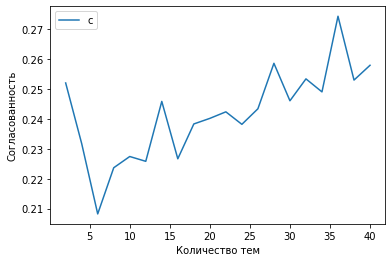

In [ ]:
import matplotlib.pyplot as plt
limit=42; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
n_topics = x[coherence_values.index(max(coherence_values))]
n_topics

36

Получилось 36 тем. 

In [ ]:
%%capture
from gensim.models import LdaMulticore, CoherenceModel
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=n_topics)

Выведем наиболее частотные ключевые слова каждой из тем.

In [ ]:
lda_model.print_topics()

[(1,
  '0.005*"друг" + 0.005*"мир" + 0.004*"нравиться" + 0.003*"рука" + 0.003*"новый" + 0.003*"интервью" + 0.003*"дом" + 0.003*"поэт" + 0.003*"поделиться" + 0.002*"двор"'),
 (25,
  '0.005*"твой" + 0.004*"язык" + 0.004*"идти" + 0.004*"русский" + 0.004*"мир" + 0.004*"блокнот" + 0.003*"прийти" + 0.003*"искать" + 0.003*"речь" + 0.003*"друг"'),
 (11,
  '0.006*"стих" + 0.005*"книга" + 0.005*"данилов" + 0.005*"стефаний" + 0.005*"новый" + 0.005*"жизнь" + 0.004*"тур" + 0.003*"ждать" + 0.003*"видеть" + 0.003*"поэт"'),
 (29,
  '0.005*"мир" + 0.005*"книга" + 0.004*"концерт" + 0.004*"любить" + 0.004*"считать" + 0.004*"осень" + 0.003*"вместе" + 0.003*"стих" + 0.003*"чувствовать" + 0.003*"бог"'),
 (6,
  '0.007*"стих" + 0.005*"друг" + 0.005*"книга" + 0.004*"данилов" + 0.004*"стефаний" + 0.004*"любить" + 0.004*"остаться" + 0.003*"чёрный" + 0.003*"нибыть" + 0.003*"синий"'),
 (20,
  '0.005*"стих" + 0.004*"песня" + 0.004*"любить" + 0.004*"писать" + 0.004*"любовь" + 0.003*"огонь" + 0.003*"жить" + 0.003*"св

Модуль `pyLDAvis` позволяет сделать интерактивную визуализацию результатов тематического моделирования.

In [ ]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4     -0.009601 -0.074147       1        1  5.452237
2     -0.035230  0.024915       2        1  5.441558
0     -0.113096  0.042874       3        1  4.836159
16    -0.015521  0.048502       4        1  4.818439
11    -0.007293 -0.030829       5        1  4.579840
35     0.007281 -0.058160       6        1  4.383476
30    -0.047428 -0.002191       7        1  4.327262
12     0.006531  0.022736       8        1  4.005683
26    -0.032994 -0.023306       9        1  3.970248
3     -0.006203 -0.041209      10        1  3.800601
8     -0.011370 -0.014049      11        1  3.644825
13    -0.002644  0.009836      12        1  3.539048
7     -0.034536  0.011243      13        1  3.235482
22    -0.025611 -0.001237      14        1  3.216189
17    -0.037531 -0.051497      15        1  3.197775
24    -0.035734  0.035506      16        1  3.154840
5      0.005900  0.003049      17        1  3.015742
28    -0.022858  0.003866      18        1  2.797089
14     0.070507 -0.029392      19        1  2.547887
18    -0.027179  0.041971      20        1  2.497674
15    -0.035596 -0.040235      21        1  2.465408
6     -0.003798 -0.076536      22        1  2.141934
31     0.037923  0.010094      23        1  2.123320
29     0.021474 -0.010867      24        1  2.078926
27     0.008902 -0.015525      25        1  1.937775
9      0.003334  0.020778      26        1  1.831884
20     0.058756  0.030444      27        1  1.674238
32     0.038442  0.081957      28        1  1.648662
19     0.022482 -0.023957      29        1  1.556930
25     0.006088  0.060753      30        1  1.555607
34     0.039780 -0.017567      31        1  1.333901
10     0.005823 -0.000793      32        1  0.848166
1      0.021602  0.000131      33        1  0.797302
21     0.046047  0.022709      34        1  0.756854
23     0.080851 -0.004981      35        1  0.572246
33     0.022500  0.045116      36        1  0.214795, topic_info=         Term        Freq       Total Category  logprob  loglift
384      поэт   88.000000   88.000000  Default  30.0000  30.0000
1222        р   17.000000   17.000000  Default  29.0000  29.0000
221      твой   97.000000   97.000000  Default  28.0000  28.0000
464      друг   96.000000   96.000000  Default  27.0000  27.0000
28      книга  121.000000  121.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
643   красный    0.097006   10.831275  Topic36  -6.4881   1.4278
1285     вера    0.096982   12.778142  Topic36  -6.4883   1.2623
793    нибыть    0.097549   22.304437  Topic36  -6.4825   0.7111
403      стих    0.104451  145.575966  Topic36  -6.4141  -1.0965
117   данилов    0.099964   43.357384  Topic36  -6.4580   0.0708

[2536 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1827     31  0.286447    абьюзер
6710      4  0.283859   авангард
6710      6  0.283859   авангард
5205     19  0.670233  авиарежим
2727      5  0.223338    автобус
...     ...       ...        ...
328      34  0.028844       язык
8737      2  0.537836     яндекс
8737      6  0.537836     яндекс
3053     17  0.259162   японский
3053     20  0.259162   японский

[5880 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 17, 12, 36, 31, 13, 27, 4, 9, 14, 8, 23, 18, 25, 6, 29, 15, 19, 16, 7, 32, 30, 28, 10, 21, 33, 20, 26, 35, 11, 2, 22, 24, 34])

Сейчас довольно много пересекающихся тем и кажется, что часть из них об одном и том же. На самом деле здесь просто недостаточно хорошо обработаны стоп-слова. Этому этапу в реальных условиях следует уделить достаточно большое внимание. Также для повышения адекватности результата стоит рассматривать не только униграммы, но и би- и три-граммы, поэкспериментироваться с количеством кластеров.